# Notes on current version:
For TOC if missing from command line try
jupyter nbextensions_configurator enable
then toggle nbextensions, restart.

1. 1.9.2020 Managed to convert ODE models for economic extension to transition model ready for stochastic simulation, using separate birth death list
            See section on SC2UIR model. Not done for other two economic extensions yet
2. 1.9.2020 Implemented stochastic simulation (Tau-leap method) using PyGom inbuilt capabilities: for SCIR simulation only so far
            Neeed to use integer N>>1, not 1.0, for stochastic simulation. Calculates in a few minutes for N=10000, rescaled ICUfrac to 0.02 (x10). N=100000 didn't finish in 10m.

# Model Definitions

## Utilities for custom extension of PyGom

In [1]:
# import required packages
import os 
import csv
from sympy import symbols, init_printing
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
import sympy
import itertools
import scipy
import datetime
import matplotlib.dates as mdates
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType, SquareLoss
from scipy.optimize import minimize

import pickle as pk
import jsonpickle as jpk

from cycler import cycler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf

/Users/n/.pyenv/versions/3.7.2/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from models import *

In [3]:
savefigs = False # whether to save specific figures for paper to .../figures directory

In [4]:

# This cell adds two methods to the DeterministicODE class of pygom
# dumpparams: stores params in a file './params/Model_Name.pk'
# loadparams: loads params from same file.  returns None if any problem finding the file.
# e.g. will be accessed by SCIR.dumparams() or SCIR.loadparams()
# This stuff needs modules os, sys, pickle as pk.

def dumpparams(self,run_id=''): # Have to add self since this will become a method
    mname = self.modelname
    dirnm = os.getcwd()
    pfile = dirnm+'/params/'+mname+'.pk'
    try:
        params = self.params.copy()
        with open(pfile,'wb') as fp:
            pk.dump(params,fp,protocol=pk.HIGHEST_PROTOCOL)
        print('dumped params to',pfile)
        if run_id != '':
            pfile2 = dirnm+'/params/'+run_id+'.pk'
            with open(pfile2,'wb') as fp:
                pk.dump(params,fp,protocol=pk.HIGHEST_PROTOCOL)
            print('dumped params to',pfile2)
    except:
        print('problem dumping params to ',pfile)


def loadparams(self,run_id=''): # Have to add self since this will become a method
    mname = self.modelname
    dirnm = os.getcwd()
    if run_id == '':
        pfile = dirnm+'/params/'+mname+'.pk'
    else:
        pfile = dirnm+'/params/'+run_id+'.pk'
    try:
        with open(pfile,'rb') as fp:
            params = pk.load(fp)
            print('loaded params from ',pfile,':')
    except:
        print("problem loading",pfile)
        return None


    nms = [x.name for x in self.param_list]
    try:
        self.params = params.copy()
        self.parameters = params.copy()
    except:
        print('problem loading the params; none loaded')
        return None
    return True

OdeClass = DeterministicOde().__class__
setattr(OdeClass,'dumpparams', dumpparams)
setattr(OdeClass,'loadparams', loadparams)





In [5]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn

In [6]:
def  print_ode2(self):
        '''
        Prints the ode in symbolic form onto the screen/console in actual
        symbols rather than the word of the symbol.
        
        Based on the PyGOM built-in but adapted for Jupyter
        Corrected by John McCaskill to avoid subscript format error
        '''
        A = self.get_ode_eqn()
        B = sympy.zeros(A.rows,2)
        for i in range(A.shape[0]):
            B[i,0] = sympy.symbols('d' + '{' + str(self._stateList[i]) + '}'+ '/dt=')
            B[i,1] = A[i]

        return B

In [7]:
# Jupyter Specifics
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

## Caution Extensions to SIR Model

### SIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S\\
\dot{I} &= \beta I S - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}


#### Variables
* $S$: Susceptible individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [8]:
# display equations
print_ode2(SIR_model)

Matrix([
[d{S}/dt=,                 -I*S*beta],
[d{I}/dt=, I*S*beta - I*gamma - I*mu],
[d{R}/dt=,                   I*gamma],
[d{D}/dt=,                      I*mu]])

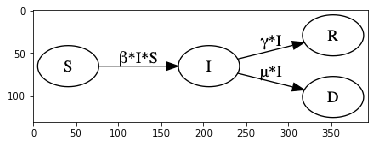

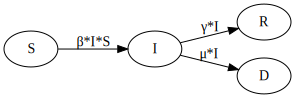

In [9]:
# display graphical representation of the model
SIR_model.get_transition_graph()

##### Derived equations, Jacobian and gradient

In [11]:
SIR_model.get_ode_eqn()

Matrix([
[                -I*S*beta],
[I*S*beta - I*gamma - I*mu],
[                  I*gamma],
[                     I*mu]])

In [12]:
SIR_model.get_jacobian_eqn()

Matrix([
[-I*beta,             -S*beta, 0, 0],
[ I*beta, S*beta - gamma - mu, 0, 0],
[      0,               gamma, 0, 0],
[      0,                  mu, 0, 0]])

In [13]:
SIR_model.get_grad_eqn()

Matrix([
[-I*S,  0,  0, 0],
[ I*S, -I, -I, 0],
[   0,  I,  0, 0],
[   0,  0,  I, 0]])

#### R0

In [14]:
from pygom.model.epi_analysis import R0

/usr/local/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  deprecated_since_version="1.6").warn()


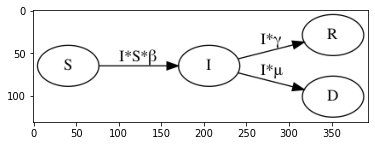

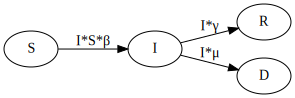

In [15]:
transition_ode = [
    Transition(origin='S',  equation='-beta*I*S'),
    Transition(origin='I',  equation='beta*I*S-gamma*I-mu*I'),
    Transition(origin='R',  equation='gamma*I'),
    Transition(origin='D',  equation='mu*I')  
    ]
ode = SimulateOde(state, param_list, ode=transition_ode)
ode = ode.get_unrolled_obj()
ode.get_transition_graph()

In [16]:
R0(ode,['I'])

0

In [17]:
import sympy.matrices.matrices
# from sympy import *

### SCIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S + c_1 S_c - c_2*S*I\\
\dot{S_c} &= - c_0 \beta I S_c - c_1 S_c + c_2*S*I\\
\dot{I} &= \beta I S - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [19]:
# display equations
print_ode2(SCIR_model)

Matrix([
[  d{S}/dt=,              -I*S*beta - I*S*c_2 + S_c*c_1],
[  d{I}/dt=, I*S*beta + I*S_c*beta*c_0 - I*gamma - I*mu],
[  d{R}/dt=,                                    I*gamma],
[  d{D}/dt=,                                       I*mu],
[d{S_c}/dt=,         I*S*c_2 - I*S_c*beta*c_0 - S_c*c_1]])

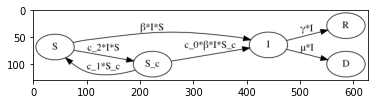

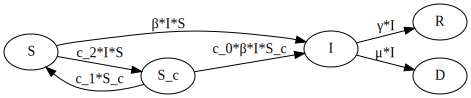

In [20]:
# display graphical representation of the model
SCIR_model.get_transition_graph()

### SC2IR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{I} &= \beta (I + c_0 I_c) S - \gamma I - \mu I + c_1 I_c - c_2 I (I + I_c)\\
\dot{I_c} &= \beta (I + c_0 I_c) S_c - \gamma I_c - \mu I_c - c_1 I_c + c_2 I (I + I_c)\\
\dot{R} & = \gamma (I + I_c)\\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

The effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. To implement this we distinguish careful and non careful infectives. We ignore infectives making the transition to caution or relaxing it.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $I$: Infected individuals non exercising pandemy precautions
* $I_c$: Infected individuals exercising pandemy precautions 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [22]:
# display equations
print_ode2(SC2IR_model)

Matrix([
[  d{S}/dt=,                           -S*beta*(I + I_c*c_0) - S*c_2*(I + I_c) + S_c*c_1],
[  d{I}/dt=,          -I*c_2*(I + I_c) - I*gamma - I*mu + I_c*c_1 + S*beta*(I + I_c*c_0)],
[  d{R}/dt=,                                                         I*gamma + I_c*gamma],
[  d{D}/dt=,                                                               I*mu + I_c*mu],
[d{I_c}/dt=, I*c_2*(I + I_c) - I_c*c_1 - I_c*gamma - I_c*mu + S_c*beta*c_0*(I + I_c*c_0)],
[d{S_c}/dt=,                      S*c_2*(I + I_c) - S_c*beta*c_0*(I + I_c*c_0) - S_c*c_1]])


\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{I} &= \beta (I + c_0 I_c) S - \gamma I - \mu I\\
\dot{I_c} &= \beta (I + c_0 I_c) S_c - \gamma I_c - \mu I_c\\
\dot{R} & = \gamma (I + I_c)\\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}


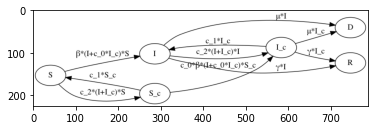

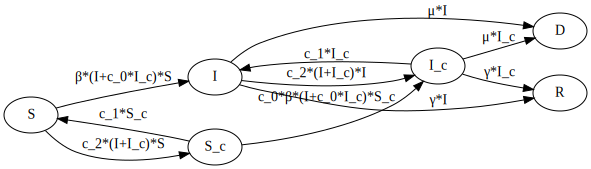

In [23]:
# display graphical representation of the model
SC2IR_model.get_transition_graph()

## Caution Extensions to SEIR Model

### SEIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S\\
\dot{E} &= \beta I S - \alpha E\\
\dot{I} &= \alpha E - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}


#### Variables
* $S$: Susceptible individuals
* $E$: Exposed individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+E+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and expose them to infection
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [25]:
# display equations
print_ode2(SEIR_model)

Matrix([
[d{S}/dt=,                -I*S*beta],
[d{E}/dt=,      -E*alpha + I*S*beta],
[d{I}/dt=, E*alpha - I*gamma - I*mu],
[d{R}/dt=,                  I*gamma],
[d{D}/dt=,                     I*mu]])

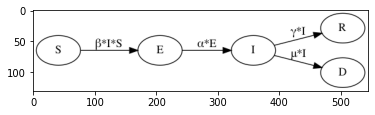

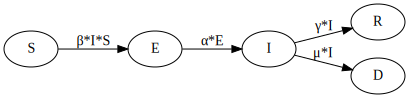

In [26]:
# display graphical representation of the model
SEIR_model.get_transition_graph()

### SCEIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S + c_1 S_c - c_2*S*I\\
\dot{S_c} &= - c_0 \beta I S_c - c_1 S_c + c_2*S*I\\
\dot{E} &= \beta I (S + c_0 S_c) - \alpha E\\
\dot{I} &= \alpha E - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [28]:
# display equations
print_ode2(SCEIR_model)

Matrix([
[  d{S}/dt=,        -I*S*beta - I*S*c_2 + S_c*c_1],
[  d{E}/dt=, -E*alpha + I*S*beta + I*S_c*beta*c_0],
[  d{I}/dt=,             E*alpha - I*gamma - I*mu],
[  d{R}/dt=,                              I*gamma],
[  d{D}/dt=,                                 I*mu],
[d{S_c}/dt=,   I*S*c_2 - I*S_c*beta*c_0 - S_c*c_1]])

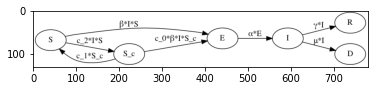

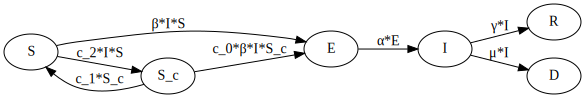

In [29]:
# display graphical representation of the model
SCEIR_model.get_transition_graph()

### SC3EIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{E} &= \beta (I + c_0 I_c) S - \alpha E  + c_1 E_c - c_2 E (I + I_c)\\
\dot{E_c} &= c_0 \beta (I + c_0 I_c) S_c - \alpha E_c  - c_1 E_c + c_2 E (I + I_c)\\
\dot{I} &= \alpha E - \gamma I - \mu I  + c_1 I_c - c_2 I (I + I_c)\\
\dot{I_c} &= \alpha E_c - \gamma I_c - \mu I_c - c_1 I_c + c_2 I (I + I_c)\\
\dot{R} & = \gamma (I + I_c) \\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I$: Infected individuals
* $I_c$: Infected individuals exercising caution
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+E_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [31]:
# display equations
print_ode2(SC3EIR_model)

Matrix([
[  d{S}/dt=,                  -S*beta*(I + I_c*c_0) - S*c_2*(I + I_c) + S_c*c_1],
[  d{E}/dt=,        -E*alpha - E*c_2*(I + I_c) + E_c*c_1 + S*beta*(I + I_c*c_0)],
[  d{I}/dt=,               E*alpha - I*c_2*(I + I_c) - I*gamma - I*mu + I_c*c_1],
[  d{R}/dt=,                                                I*gamma + I_c*gamma],
[  d{D}/dt=,                                                      I*mu + I_c*mu],
[d{I_c}/dt=,         E_c*alpha + I*c_2*(I + I_c) - I_c*c_1 - I_c*gamma - I_c*mu],
[d{S_c}/dt=,             S*c_2*(I + I_c) - S_c*beta*c_0*(I + I_c*c_0) - S_c*c_1],
[d{E_c}/dt=, E*c_2*(I + I_c) - E_c*alpha - E_c*c_1 + S_c*beta*c_0*(I + I_c*c_0)]])

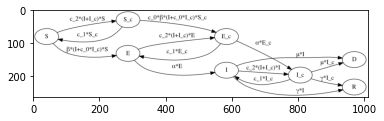

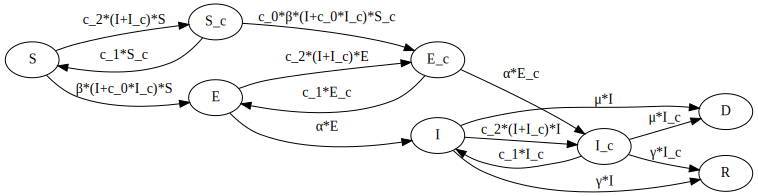

In [32]:
# display graphical representation of the model
SC3EIR_model.get_transition_graph()

## Caution Extensions to SEI3R Model

### SEI3R model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S\\
\dot{E} &=(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3 ) S - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

This model (by Dr. Alison for example) involves exposed but not infectious individuals and three classes of infective states with increasing severity.
The latter two involve hospitalization with the last in ICU.

#### Variables
* $S$: Susceptible individuals living as normal
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+E+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

#### Implementation
Using PyGOM, we will set up the model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [34]:
# display equations
print_ode2(SEI3R_model)

Matrix([
[  d{S}/dt=,           -S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[  d{E}/dt=, -E*alpha + S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[d{I_1}/dt=,                     E*alpha - I_1*gamma_1 - I_1*p_1],
[d{I_2}/dt=,                     I_1*p_1 - I_2*gamma_2 - I_2*p_2],
[d{I_3}/dt=,                      I_2*p_2 - I_3*gamma_3 - I_3*mu],
[  d{R}/dt=,             I_1*gamma_1 + I_2*gamma_2 + I_3*gamma_3],
[  d{D}/dt=,                                              I_3*mu]])

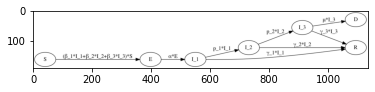

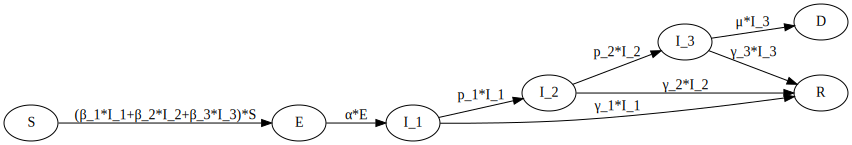

In [35]:
# display graphical representation of the model
SEI3R_model.get_transition_graph()

### SCEI3R model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3 ) (S + c_0 S_c) - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I_3. To implement this we would need to further distinguish careful and non careful infectives at least up to the I_1 level. This is done in the SC3EI3R model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible




#### Implementation
Using PyGOM, we will set up the model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [37]:
# display equations
print_ode2(SCEI3R_model)

Matrix([
[  d{S}/dt=,                                      -I_3*S*c_2 - S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) + S_c*c_1],
[  d{E}/dt=, -E*alpha + S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) + S_c*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[d{I_1}/dt=,                                                                      E*alpha - I_1*gamma_1 - I_1*p_1],
[d{I_2}/dt=,                                                                      I_1*p_1 - I_2*gamma_2 - I_2*p_2],
[d{I_3}/dt=,                                                                       I_2*p_2 - I_3*gamma_3 - I_3*mu],
[  d{R}/dt=,                                                              I_1*gamma_1 + I_2*gamma_2 + I_3*gamma_3],
[  d{D}/dt=,                                                                                               I_3*mu],
[d{S_c}/dt=,                                 I_3*S*c_2 - S_c*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) - S_c*c_1]])

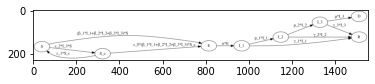

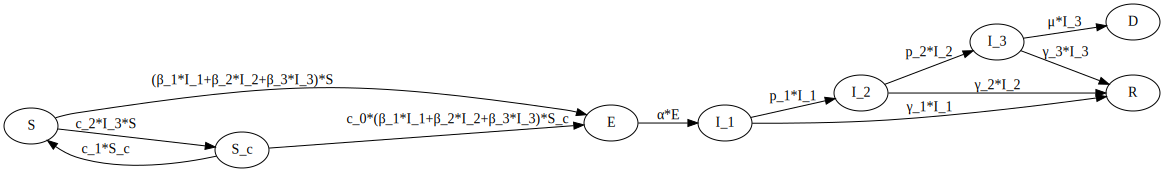

In [38]:
# display graphical representation of the model
SCEI3R_model.get_transition_graph()

### SC3EI3R model with caution distinguished $E$ and  𝐼1

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3 ) S - a E + c_1 E_c - c_2*E*I_3\\
\dot{E_c} &=(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3 ) c_0 S_c - a E - c_1 E_c + c_2*E*I_3\\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 + c_1 I_{1c} - c_2*I_{1c}*I_3\\
\dot{I_{1c}} &= a E_c - \gamma_1 I_{1c} - p_1 I_{1c} - c_1 I_{1c} + c_2*I_{1c}*I_3\\
\dot{I_2} &= p_1 (I_1 + I_{1c}) -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 (I_1 + I_{1c}) + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Here, the effect of caution is quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. To implement this we distinguish careful and non careful exposed and infectives up to the I_1 level. Once in hospital there is no difference, since all caution is executed wrt infected patients.
We ignore transition in caution among infected intervals as a second order effect: could be included as in SC2IR model.


#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals living as normal - infected but not yet infectious or symptomatic
* $E_c$: Exposed individuals exercising pandemy precautions
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes. Split non hospital cases by caution.
  * $I_1$: Mild infection (hospitalization not required), living as normal
  * $I_{1c}$: Mild infection (hospitalization not required), exercising caution
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+E_c+I_{1c}+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

####  Implementation

In [40]:
# display equations
print_ode2(SC3EI3R_model)

Matrix([
[  d{S}/dt=,                  -I_3*S*c_2 - S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3 + I_c*beta_1*c_0) + S_c*c_1],
[  d{E}/dt=,        -E*I_3*c_2 - E*alpha + E_c*c_1 + S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3 + I_c*beta_1*c_0)],
[d{I_1}/dt=,                                           E*alpha - I_1*I_3*c_2 - I_1*gamma_1 - I_1*p_1 + I_c*c_1],
[d{I_2}/dt=,                                                         I_1*p_1 - I_2*gamma_2 - I_2*p_2 + I_c*p_1],
[d{I_3}/dt=,                                                                    I_2*p_2 - I_3*gamma_3 - I_3*mu],
[  d{R}/dt=,                                             I_1*gamma_1 + I_2*gamma_2 + I_3*gamma_3 + I_c*gamma_1],
[  d{D}/dt=,                                                                                            I_3*mu],
[d{I_c}/dt=,                                         E_c*alpha + I_1*I_3*c_2 - I_c*c_1 - I_c*gamma_1 - I_c*p_1],
[d{S_c}/dt=,             I_3*S*c_2 - S_c*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3 + I_

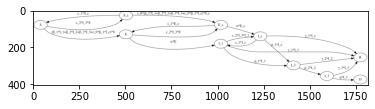

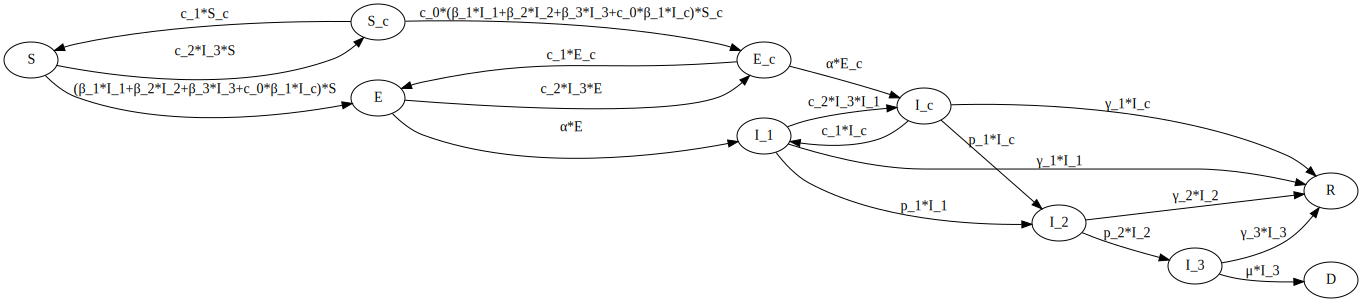

In [41]:
# display graphical representation of the model
SC3EI3R_model.get_transition_graph()

## Caution Extensions to SEIR Model with Economic Supression
This model is an extension of the cautionary model to include a class of susceptibles $S_u$ who are impervious to caution. 
The main influencer for this class is the economy, which we introduce as a new state variable W, normalized to 1 in the absence of pandemic.
The model assumption is that fractional depression of the economy influences some susceptibles (both cautioned and uncautioned) to become uncautionable,
with a rate coefficient proportional to the economic depression (1-W). The economy itself is mdoelled with logistic growth to a state 1 in the absence of pandemic
and 1- $\kappa S_c$ with pandemic. i.e. individuals exercising caution are the main correlate of economic depression (but the only suppressor for the pandemic).
As for the cautioned class, uncautionable individuals also return to normal sussceptibles with exponential decay at rate $k_1$.

### SC2UIR model

#### Equations
\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c) -  k_u (1 - W) S + k_1 S_u\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c) -  k_u (1 - W) S_c\\
\dot{I} &= \beta (I + c_0 I_c) S - \gamma I - \mu I + c_1 I_c - c_2 I (I + I_c)\\
\dot{I_c} &= c_0 \beta (I + c_0 I_c) S_c - \gamma I_c - \mu I_c - c_1 I_c + c_2 I (I + I_c)\\
\dot{R} & = \gamma (I + I_c) \\
\dot{D} & = \mu (I + I_c) \\
\dot{S_u} & = -\beta (I + c_0 I_c) S_u + k_u (1 - W) (S + S_c)  - k_1 S_u \\
\dot{W} & = k_w W (1 - \kappa S_c - W)
\end{split}
\end{equation}

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $S_u$: Susceptible individuals immune to caution because of economic downturn
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I$: Infected individuals
* $I_c$: Infected individuals exercising caution
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $W$: Economic status obeying a logistic law with caution individuals downturning
* $N=S+S_c+S_u+E+E_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : inverse duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible
* four parameters coupling to economy and uncautionable individuals
    - k_w : rate coefficient of economy equilibration
    - k_u : rate coefficient of transition from uncautioned to uncautionable
    - k_1 : inverse duration of uncautionable state
    - $\kappa$ : economic downturn of caution (proportional to number cautious)

####  Implementation

In [44]:
# display equations
print_ode2(SC2UIR_model)

Matrix([
[  d{S}/dt=,                 -S*beta*(I + I_c*c_0) - S*c_2*(I + I_c) - S*k_u*(1 - W) + S_c*c_1 + S_u*k_1],
[  d{I}/dt=, -I*c_2*(I + I_c) - I*gamma - I*mu + I_c*c_1 + S*beta*(I + I_c*c_0) + S_u*beta*(I + I_c*c_0)],
[  d{R}/dt=,                                                                         I*gamma + I_c*gamma],
[  d{D}/dt=,                                                                               I*mu + I_c*mu],
[d{I_c}/dt=,                 I*c_2*(I + I_c) - I_c*c_1 - I_c*gamma - I_c*mu + S_c*beta*c_0*(I + I_c*c_0)],
[d{S_c}/dt=,                    S*c_2*(I + I_c) - S_c*beta*c_0*(I + I_c*c_0) - S_c*c_1 - S_c*k_u*(1 - W)],
[d{S_u}/dt=,                          S*k_u*(1 - W) + S_c*k_u*(1 - W) - S_u*beta*(I + I_c*c_0) - S_u*k_1],
[  d{W}/dt=,                                                                  W*k_w*(-S_c*kappa - W + 1)]])

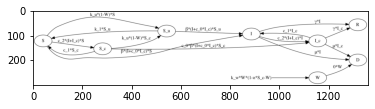

In [45]:
SC2UIR_model.get_transition_graph()

In [46]:
# ode = SimulateOde(state, param_list, transition=transition)
# ode = ode.get_unrolled_obj()
# R0(ode, ['I','I_c'])   # produces error, no valid subset found

### SC3UEIR model

#### Equations
\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c) -  k_u (1 - W) S + k_1 S_u\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c) -  k_u (1 - W) S_c\\
\dot{E} &= \beta (I + c_0 I_c) (S + S_u) - \alpha E + c_1 E_c - c_2 E (I + I_c)\\
\dot{E_c} &= c_0 \beta (I + c_0 I_c) S_c - \alpha E_c - c_1 E_c + c_2 E (I + I_c)\\
\dot{I} &= \alpha E - \gamma I - \mu I + c_1 I_c - c_2 I (I + I_c)\\
\dot{I_c} &= \alpha E_c - \gamma I_c - \mu I_c - c_1 I_c + c_2 I (I + I_c)\\
\dot{R} & = \gamma (I + I_c) \\
\dot{D} & = \mu (I + I_c) \\
\dot{S_u} & = -\beta (I + c_0 I_c) S_u + k_u (1 - W) (S + S_c)  - k_1 S_u \\
\dot{W} & = k_w W (1 - \kappa S_c - W)
\end{split}
\end{equation}

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $S_u$: Susceptible individuals immune to caution because of economic downturn
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I$: Infected individuals
* $I_c$: Infected individuals exercising caution
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $W$: Economic status obeying a logistic law with caution individuals downturning
* $N=S+S_c+S_u+E+E_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : inverse duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible
* four parameters coupling to economy and uncautionable individuals
    - k_w : rate coefficient of economy equilibration
    - k_u : rate coefficient of transition from uncautioned to uncautionable
    - k_1 : inverse duration of uncautionable state
    - $\kappa$ : economic downturn of caution (proportional to number cautious)

####  Implementation

In [10]:
# display equations
print_ode2(SC3UEIR_model)

Matrix([
[  d{S}/dt=, -S*beta*(I + I_c*c_0) - S*c_2*(I + I_c) - S*k_u*(1 - W) + S_c*c_1 + S_u*k_1],
[  d{E}/dt=,         -E*alpha - E*c_2*(I + I_c) + E_c*c_1 + beta*(I + I_c*c_0)*(S + S_u)],
[  d{I}/dt=,                        E*alpha - I*c_2*(I + I_c) - I*gamma - I*mu + I_c*c_1],
[  d{R}/dt=,                                                             gamma*(I + I_c)],
[  d{D}/dt=,                                                                mu*(I + I_c)],
[d{I_c}/dt=,                  E_c*alpha + I*c_2*(I + I_c) - I_c*c_1 - I_c*gamma - I_c*mu],
[d{S_c}/dt=,    S*c_2*(I + I_c) - S_c*beta*c_0*(I + I_c*c_0) - S_c*c_1 - S_c*k_u*(1 - W)],
[d{E_c}/dt=,          E*c_2*(I + I_c) - E_c*alpha - E_c*c_1 + S_c*beta*c_0*(I + I_c*c_0)],
[d{S_u}/dt=,                   -S_u*beta*(I + I_c*c_0) - S_u*k_1 + k_u*(1 - W)*(S + S_c)],
[  d{W}/dt=,                                                  W*k_w*(-S_c*kappa - W + 1)]])

### SC3UEI3R model

#### Equations 

\begin{equation}
\begin{split}
\dot{S} &={} -(\beta_1 (I_1 + c_0 I_c) + \beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2 S I_3 - S k_u (1-W) + k_1 S_u\\
\dot{S_c} &={} - c_0 (\beta_1 (I_1 + c_0 I_c) + \beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2 S I_3 - k_u (1 - W) S_c \\
\dot{E} &= \beta_1 (I_1 + c_0 I_c) (S + S_u) - \alpha E + c_1 E_c - c_2 I_3 E\\
\dot{E_c} &= c_0 \beta_1 (I_1 + c_0 I_c) S_c - \alpha E_c - c_1 E_c + c_2 I_3 E\\
\dot{I_1} &= \alpha E - \gamma_1 I_1 - p_1 I_1 + c_1 I_c - c_2 I_3 I_1\\
\dot{I_c} &= \alpha E_c - \gamma_1 I_c - p_1 I_c - c_1 I_c + c_2 I_3 I_1\\
\dot{I_2} &= p_1 (I_1 + I_c) -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\ 
\dot{R} & = \gamma_1 (I_1 + I_c) +\gamma_2 I_2 + \gamma_3 I_3\\
\dot{D} & = \mu (I_3) \\
\dot{S_u} & = -(\beta_1 (I_1 + c_0 I_c)+\beta_2 I_2 + \beta_3 I_3) S_u + k_u (1 - W)(S+ S_c)  - k_1 S_u \\
\dot{W} & = k_w W (1 - \kappa S_c - W)\\
\end{split}
\end{equation}

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $S_u$: Susceptible individuals immune to caution because of economic downturn
* $W$: Economic status obeying a logistic law with caution individuals downturning
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes. Split non hospital cases by caution.
  * $I_1$: Mild infection (hospitalization not required), living as normal
  * $I_c$: Mild infection (hospitalization not required), exercising caution
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+S_u+E+E_c+I_1+I_c+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - $c_0$ : reduction factor for exposure for cautioned susceptibles

    - $c_1$ : inverse duration of caution (exponential decay time constant in days)

    - $c_2$ : rate constant for transition from uncautioned to cautioned susceptible
* four parameters coupling to economy and uncautionable individuals
    - $k_w$ : rate coefficient of economy equilibration
    - $k_u$ : rate coefficient of transition from uncautioned to uncautionable
    - $k_1$ : inverse duration of uncautionable state
    - $\kappa$ : economic downturn of caution (proportional to number cautious)

####  Implementation

In [50]:
# display equations
print_ode2(SC3UEI3R_model) # name needs to be that of current model

Matrix([
[  d{S}/dt=, -I_3*S*c_2 - S*k_u*(1 - W) + S*(-I_2*beta_2 - I_3*beta_3 - beta_1*(I_1 + I_c*c_0)) + S_c*c_1 + S_u*k_1],
[  d{E}/dt=,                                      -E*I_3*c_2 - E*alpha + E_c*c_1 + beta_1*(I_1 + I_c*c_0)*(S + S_u)],
[d{I_1}/dt=,                                                E*alpha - I_1*I_3*c_2 - I_1*gamma_1 - I_1*p_1 + I_c*c_1],
[d{I_2}/dt=,                                                               -I_2*gamma_2 - I_2*p_2 + p_1*(I_1 + I_c)],
[d{I_3}/dt=,                                                                         I_2*p_2 - I_3*gamma_3 - I_3*mu],
[  d{R}/dt=,                                                        I_2*gamma_2 + I_3*gamma_3 + gamma_1*(I_1 + I_c)],
[  d{D}/dt=,                                                                                                 I_3*mu],
[d{I_c}/dt=,                                              E_c*alpha + I_1*I_3*c_2 - I_c*c_1 - I_c*gamma_1 - I_c*p_1],
[d{S_c}/dt=,     I_3*S*c_2 - S_c*c_0*(I_2*beta_